# Political Evolution Simulator

This notebook implements a political simulation based on Selectorate Theory, where leaders evolve public/private goods allocation strategies over generations. Voters choose candidates based on ideology and expected benefits.

In [ ]:
import numpy as np

# --- Parameters ---
N_VOTERS = 100
N_CANDIDATES = 4
N_GENERATIONS = 2000
RESOURCE_POOL = 1000
PUBLIC_GOODS_MUT_STD = 0.05
POLICY_MUT_STD = 2
THETA = 15
TAU = 0.6
PHI = 0.3

np.random.seed(1)

## Voter Class
Each voter has an ideology and a risk type. They vote based on policy alignment and payoff expectations.

In [10]:
class Voter:
    def __init__(self, ideology, risk_type='safe'):
        self.ideology = ideology
        self.risk_type = risk_type

    def utility(self, candidate, coalition_prob, included):
        policy_loss = -(self.ideology - candidate.policy) ** 2
        public_payoff = candidate.alpha * (RESOURCE_POOL / N_VOTERS)
        private_payoff = (1 - candidate.alpha) * (RESOURCE_POOL / N_VOTERS) if included else 0
        return policy_loss + public_payoff + private_payoff

    def inclusion(self, candidate, coalition_prob):
        max_dist = THETA
        threshold = TAU if self.risk_type == 'risk' else PHI
        return abs(self.ideology - candidate.policy) <= max_dist and coalition_prob >= threshold

## Candidate Class
Candidates have a policy and public/private goods strategy. They mutate their strategy to evolve.

In [11]:
class Candidate:
    def __init__(self, policy, alpha):
        self.policy = policy
        self.alpha = alpha
        self.supporters = set()
        self.winning_coalition = set()

    def mutate(self, mutate_policy=True):
        new_alpha = np.clip(self.alpha + np.random.normal(0, PUBLIC_GOODS_MUT_STD), 0, 1)
        new_policy = self.policy + np.random.normal(0, POLICY_MUT_STD) if mutate_policy else self.policy
        new_policy = np.clip(new_policy, 0, 100)
        return Candidate(new_policy, new_alpha)

## Simulation Class
Handles the election process, coalition formation, and candidate evolution.

In [12]:
class ElectionSim:
    def __init__(self):
        self.voters = [Voter(np.random.uniform(0, 100), risk_type=np.random.choice(['safe', 'risk'])) for _ in range(N_VOTERS)]
        self.candidates = [Candidate(np.random.uniform(0, 100), np.random.uniform(0, 1)) for _ in range(N_CANDIDATES)]

    def run_generation(self, mutate_policy=True):
        ballots = []
        for voter in self.voters:
            utilities = []
            for candidate in self.candidates:
                coalition_prob = len(candidate.winning_coalition) / N_VOTERS if candidate.winning_coalition else 1 / N_VOTERS
                included = voter.inclusion(candidate, coalition_prob)
                utilities.append(voter.utility(candidate, coalition_prob, included))
            chosen = np.argmax(utilities)
            ballots.append(chosen)

        for idx, candidate in enumerate(self.candidates):
            candidate.supporters = {i for i, b in enumerate(ballots) if b == idx}
            coalition_size = int(0.5 * N_VOTERS)
            supporters_list = list(candidate.supporters)
            np.random.shuffle(supporters_list)
            candidate.winning_coalition = set(supporters_list[:coalition_size])

        coalition_sizes = [len(c.winning_coalition) for c in self.candidates]
        winner_idx = np.argmax(coalition_sizes)
        winner = self.candidates[winner_idx]

        new_candidates = [winner]
        while len(new_candidates) < N_CANDIDATES:
            new_cand = winner.mutate(mutate_policy=mutate_policy)
            new_candidates.append(new_cand)
        self.candidates = new_candidates

        return winner, coalition_sizes

    def run_simulation(self, generations=N_GENERATIONS, mutate_policy=True):
        history = []
        for gen in range(generations):
            winner, coalition_sizes = self.run_generation(mutate_policy=mutate_policy)
            history.append({
                'generation': gen,
                'winner_policy': winner.policy,
                'winner_alpha': winner.alpha,
                'coalition_sizes': coalition_sizes,
            })
        return history

## Run Simulation
Execute the simulation and observe the evolution of candidate strategies over generations.

In [13]:
sim = ElectionSim()
results = sim.run_simulation(mutate_policy=True)

final = results[-1]
print(f"Final winner policy: {final['winner_policy']:.2f}")
print(f"Final winner alpha (public/private split): {final['winner_alpha']:.2f}")
print(f"Final coalition sizes: {final['coalition_sizes']}")

Final winner policy: 50.68
Final winner alpha (public/private split): 0.65
Final coalition sizes: [50, 42, 3, 0]


## Plot Results
Visualize how winning policies and public/private allocations evolve over time.

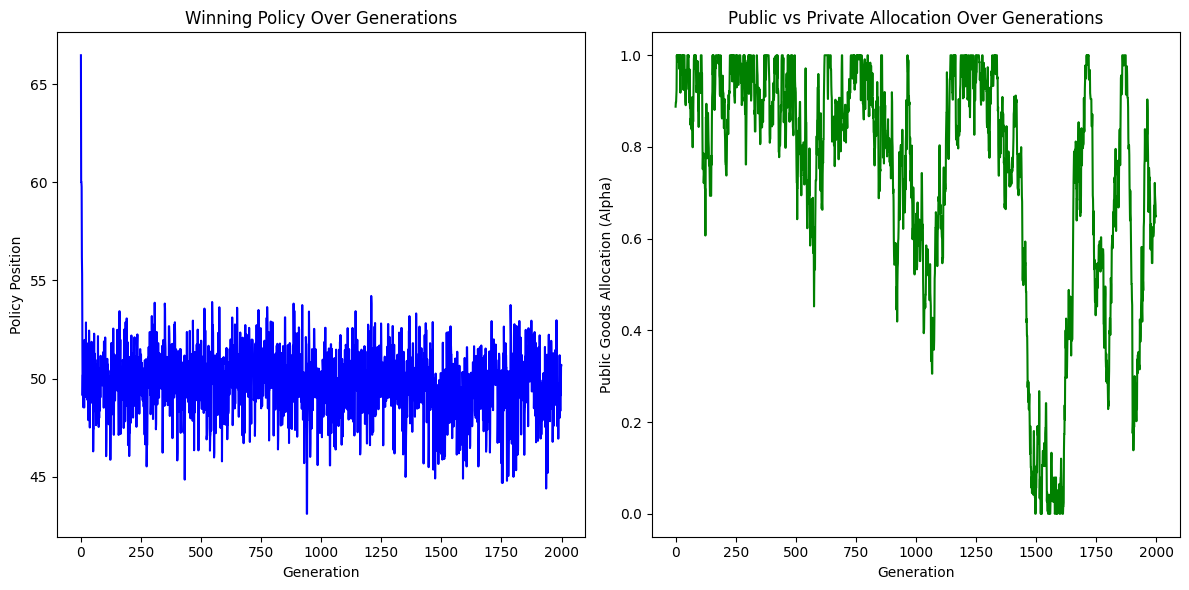

In [14]:
import matplotlib.pyplot as plt

policies = [r['winner_policy'] for r in results]
alphas = [r['winner_alpha'] for r in results]
generations = [r['generation'] for r in results]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(generations, policies, label='Winning Policy', color='blue')
plt.xlabel('Generation')
plt.ylabel('Policy Position')
plt.title('Winning Policy Over Generations')

plt.subplot(1, 2, 2)
plt.plot(generations, alphas, label='Winning Alpha', color='green')
plt.xlabel('Generation')
plt.ylabel('Public Goods Allocation (Alpha)')
plt.title('Public vs Private Allocation Over Generations')

plt.tight_layout()
plt.show()